# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [120]:
# Import libraries necessary for this project
!pip install numpy pandas seaborn

import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [121]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [122]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [10, 222, 304]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,3366,5403,12974,4400,5977,1744
1,5041,1115,2856,7496,256,375
2,161,7460,24773,617,11783,2410


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

First lets find out how the items in the sample expend their money.

In [123]:
#finding how the relative money of each sample is distributed
relative = data.apply(lambda x: x/x.sum(), axis=1)
display(relative.iloc[indices])

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
10,0.099398,0.159550,0.383121,0.129931,0.176500,0.051500
222,0.294125,0.065056,0.166637,0.437365,0.014937,0.021880
304,0.003411,0.158037,0.524807,0.013071,0.249619,0.051055


Now lets find out how big are the samples relative to the data:

In [124]:
#how big are the business in samples?
display(data.sum(axis=1).rank(pct=True).iloc[indices])

10     0.640909
222    0.236364
304    0.811364
dtype: float64

**Answer:**

- Item `10` consumes mainly grocery, frozen and cleaning but no delicatessen nor fresh products. A **grocery store_ fi or a _mini-market**

- Item `222` has a small budget consisting mainly of fresh, grocery and frozen products. A **small fast food restaurant** .

- Item `304` has a big budget consisting of grocery, Milk, grocery and cleaning products. Probably a  **medium sized grocery store**. 

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [125]:
drop_feature= 'Delicatessen'
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop([drop_feature, ], axis = 1)

# TODO: Split the data into training and testing sets using the given feature as the target
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, 
                                                    data[drop_feature], 
                                                    test_size=0.25, 
                                                    random_state=42)


# TODO: Create a decision tree regressor and fit it to the training set
from sklearn.tree import  DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set

predicted = regressor.predict(X_test)
print 'Sample of predicition:',
print zip(predicted, y_test)[:10], '\n'



score = regressor.score(X_test, y_test)
print "Data has a score of %s to predict %s."%(score, drop_feature)

Sample of predicition: [(16523.0, 3636), (1409.0, 167), (602.0, 1022), (548.0, 615), (195.0, 522), (5137.0, 686), (259.0, 11), (3508.0, 2342), (1059.0, 2125), (468.0, 378)] 

Data has a score of -2.2547115372 to predict Delicatessen.


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**
Predicting `Delicatessen` with the other data using an DecisionTreeRegressor had a score of **-2.254** therefore the regressor couldn't fit the data. This means this regressor can't predict `Delicatessen` comsumption using the training data.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

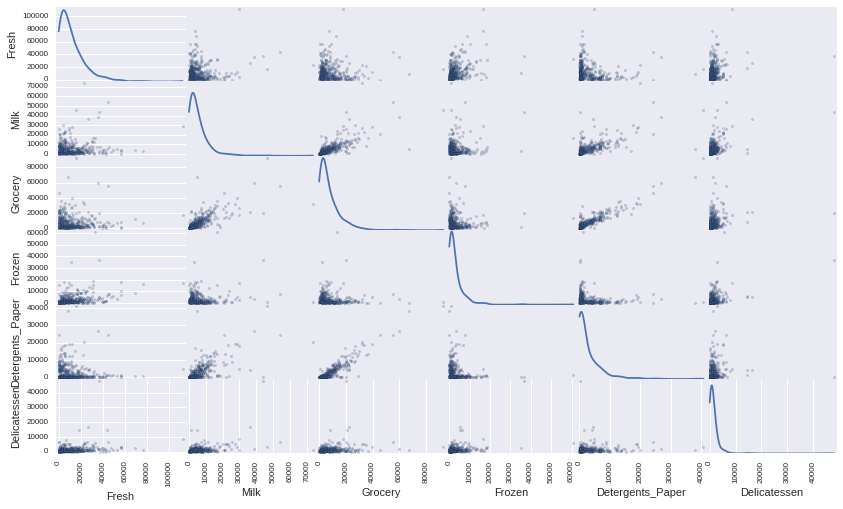

In [126]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');


### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**
The pairs (`Grocery`, `Detergents_Paper`) (`Grocery`, `Milk`) seems to be linearly correlated. The tested feature, `Delicatessen` does not seem to me correlated to any other feature. This information corroborates with the hypothesis that `Delicatessen` is not relevant to predict the other features neither about `Delicatessen` feature's relevance. 

All data seems to have some distribution with a long tail like a chi-squared distribution.  




## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

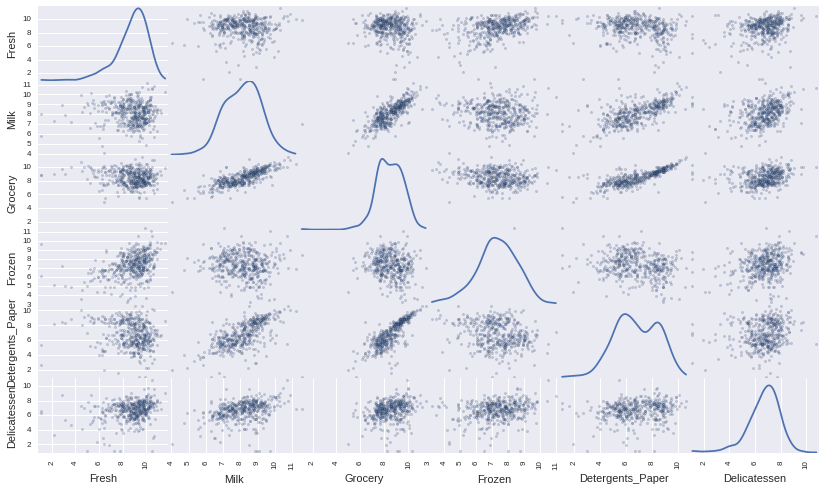

In [127]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)
# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [128]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.121480,8.594710,9.470703,8.389360,8.695674,7.463937
1,8.525360,7.016610,7.957177,8.922125,5.545177,5.926926
2,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [129]:
outliers = {}
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = log_data[feature].quantile(0.25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = log_data[feature].quantile(0.75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5

    # Display the outliers
    _out_liers = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    print "Data points considered outliers for the feature '{}' are {}".format(feature, len(_out_liers))
    print(list(_out_liers.index))
    for i in list(_out_liers.index):
        outliers[i] = outliers.get(i, 0) + 1
    #outliers.intersection_update(list(_out_liers.index))
    
    #print "Q1 = %s \t Q3 = %s \tIQR=%s"% (Q1, Q3, step)

    #display()
    
# OPTIONAL: Select the indices for data points you wish to remove
#outliers  = []

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers.keys()]).reset_index(drop = True)
#display(good_data)


Data points considered outliers for the feature 'Fresh' are 16
[65, 66, 81, 95, 96, 128, 171, 193, 218, 304, 305, 338, 353, 355, 357, 412]
Data points considered outliers for the feature 'Milk' are 4
[86, 98, 154, 356]
Data points considered outliers for the feature 'Grocery' are 2
[75, 154]
Data points considered outliers for the feature 'Frozen' are 10
[38, 57, 65, 145, 175, 264, 325, 420, 429, 439]
Data points considered outliers for the feature 'Detergents_Paper' are 2
[75, 161]
Data points considered outliers for the feature 'Delicatessen' are 14
[66, 109, 128, 137, 142, 154, 183, 184, 187, 203, 233, 285, 289, 343]


### Question 4
*Are there any data points considered outliers for more than one feature? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

In [130]:
def invertDictionary(orig_dict):
    result = {} # or change to defaultdict(list)
    for k, v in orig_dict.iteritems():
        result.setdefault(v, []).append(k)
    return result    
number_of_features_outlier = invertDictionary(outliers)
#del number_of_features_outlier[1]
print "These are the indices of outliers in 2 features: ",  number_of_features_outlier[2]
print "These are the indices of outliers in 3 features:",  number_of_features_outlier[3]

These are the indices of outliers in 2 features:  [128, 65, 66, 75]
These are the indices of outliers in 3 features: [154]


**Answer:**
Yes, there are elements like `75`, and `154` which are outliers in two or more features.

In the item above I've followed Turkey's method and choose all elements _with at least one feature being outlier_.

Droping an outlier from the data may not be a good pratice. A more reasonable option would be not including the outliers in the analysis and trying to find out why there are outliers.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.4993,-0.0976,0.4109,0.4511,-0.1280,0.7595,0.1579
Dimension 2,0.2259,0.6008,0.1370,0.0852,0.6300,-0.0376,0.4634
Dimension 3,0.1049,0.7452,-0.1544,0.0204,-0.2670,0.2349,-0.5422
Dimension 4,0.0978,-0.2667,-0.1375,-0.0710,0.7133,0.3157,-0.5445
Dimension 5,0.0488,0.0114,0.7083,0.3168,0.0671,-0.4729,-0.4120
Dimension 6,0.0233,0.0543,0.5177,-0.8267,-0.0471,0.2080,0.0094


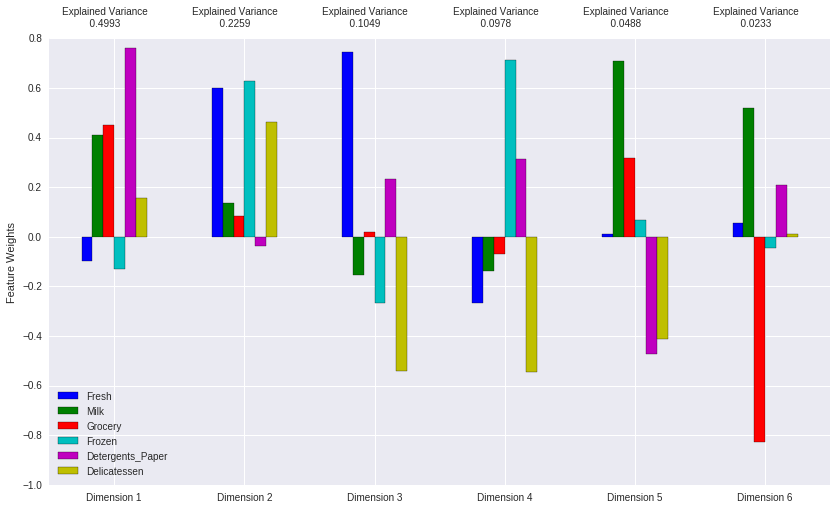

In [131]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(good_data)
# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)
#display(pca_samples)
#display(pca_samples)
# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)
display(pca_results)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**
The first and second principal components explaing together  72.5% of the variance. The first four p.c. explain 93.5% of the variance.

The discription of the first four dimentsions are as follow:
1. How much a costumer spends in milk, grocery and detergent.  A grocery store would have high value in this dimension 
2. How much a costumer in fresh, frozen food, and delicatessen. A restaurant or a hotel would have a high value in this dimension
3. This dimension increases with fresh food and decreases with delicatessen. This dimension may explain for instance the variance  between a  hotel and grocery store.
4. This dimension increases with frozen food and drecreases with delicatessen. This dimension would explain the difference between hotel and a restaurant.


### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [132]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,2.1793,0.5069,-0.8243,1.0031,-0.4516,-0.3107
1,-1.8949,0.1462,-0.3592,1.4422,0.1146,-0.5495
2,3.7184,-2.3334,-2.6179,0.3606,-0.6389,-0.6067


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [133]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
display(reduced_data.head())
#reduced_data.describe()

,Dimension 1,Dimension 2
0,1.779322,-0.660449
1,1.882034,0.461741
2,1.993507,1.247080
3,-0.998581,1.369364
4,0.993847,2.078314


### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [134]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,2.1793,0.5069
1,-1.8949,0.1462
2,3.7184,-2.3334


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**
K-means will create clusters of fully separated classes. It assumes the classes are convex (the class limits will draw some convex shapes like Voronoi Diagrams.That means you can't draw classes that surround each other using kmeans.

On other hand Gaussian mixtures may create  overlapping clusters, giving a probability of each element to belong to each class.


Being not clear how well separeted are the classes in this data (a grocery store may have a restaurants clients and that would make the two classes dependent) I choose **GMM clustering** for this data.

Ps: K-means is a special case of Gaussian Mixture model.



### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [135]:
# TODO: Apply your clustering algorithm of choice to the reduced data 

from sklearn.mixture import GMM
preds = {}
centers = {}
sample_preds = {}
score = {}



for n in range(2, 20):
    print " n_components=%s"%n, 
    clusterer = GMM(n_components=n)

    # TODO: Predict the cluster for each data point
    preds[n] = clusterer.fit_predict(reduced_data)


    # TODO: Find the cluster centers
    centers[n] = clusterer.means_
    #print "Centers = {}".format(centers[n])

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds[n] = clusterer.predict(pca_samples )
    #display(sample_preds)
    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    from sklearn.metrics import silhouette_score
    score[n] = silhouette_score(reduced_data, preds[n])
    print "Score = {}".format(score[n])
    
    
optimal = 2
preds = preds[optimal]
centers = centers[optimal]
sample_preds = sample_preds[optimal]
score = score[optimal]


 n_components=2 Score = 0.443601474015
 n_components=3 Score = 0.357294514249
 n_components=4 Score = 0.291748560968
 n_components=5 Score = 0.268398207036
 n_components=6 Score = 0.31104164006
 n_components=7 Score = 0.298279565763
 n_components=8 Score = 0.312615487024
 n_components=9 Score = 0.325757183059
 n_components=10 Score = 0.250939822926
 n_components=11 Score = 0.232814034574
 n_components=12 Score = 0.207818429499
 n_components=13 Score = 0.169327134503
 n_components=14 Score = 0.19227826681
 n_components=15 Score = 0.159419606298
 n_components=16 Score = 0.137098652971
 n_components=17 Score = 0.181878075135
 n_components=18 Score = 0.0947582559544
 n_components=19 Score = 0.155909820796


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**

2 clusters has the best silhouette score (0,44) in the tested range of number of clusters. 

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

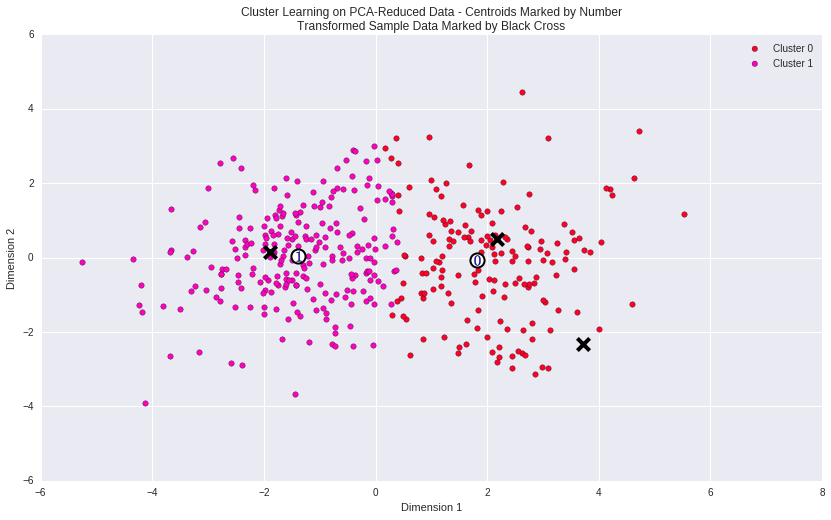

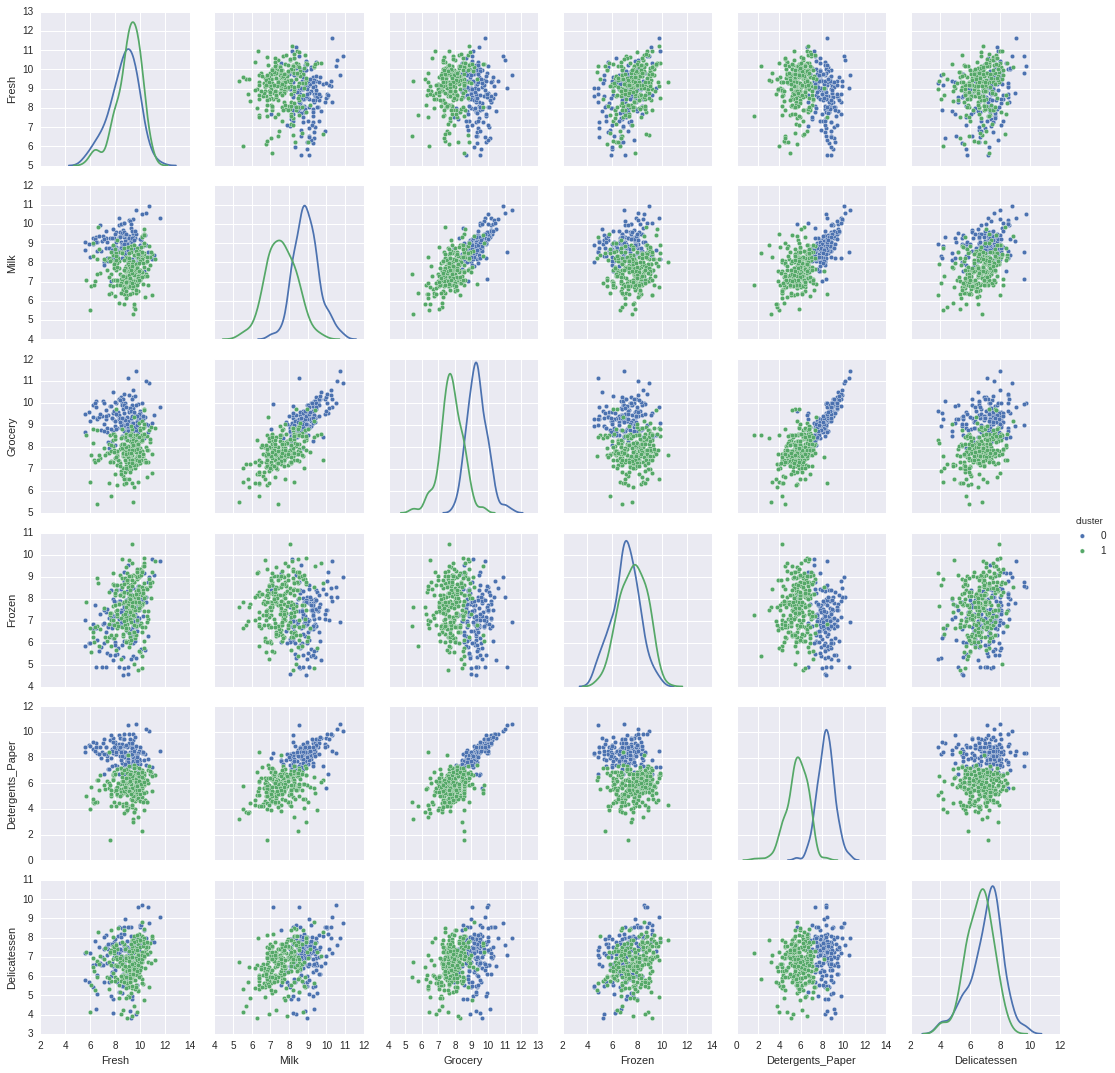

In [136]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)
predito = pd.concat([good_data, pd.Series(preds, name='cluster')], axis=1)
sns.pairplot(predito, hue='cluster', vars=[u'Fresh', u'Milk', u'Grocery', u'Frozen', u'Detergents_Paper',
       u'Delicatessen'], diag_kind='kde')

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [137]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,6079,7042,10241,1275,3546,1159
Segment 1,8967,1920,2437,2081,309,741


In [138]:
#sns.pairplot(log_data, kind='reg',hue=preds)
type(log_data)

pandas.core.frame.DataFrame

### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

Cluster 0 represents establishments consuming fresh and frozen products. These may include restaurants, fast foods and coffee shops.
Cluster 1 represents establishments that may sell fresh and frozen prodducts but also grocery and cleaning products. This Segment may include hotels and  grocery stores.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [139]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


**Answer:**

Predicted - Cluster

**1** _grocery store_ or a mini-market_ - grocery store or hotel

**2**  _A small fast food restaurant_ - restaurants and coffee shops

**3** _Probably a sized grocery store_ - grocery store or hotel


All samples predictions and cluster segmentation seems consistent. 

## Conclusion

### Question 10
*Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services. If the wholesale distributor wanted to change its delivery service from 5 days a week to 3 days a week, how would you use the structure of the data to help them decide on a group of customers to test?*  
**Hint:** Would such a change in the delivery service affect all customers equally? How could the distributor identify who it affects the most?

**Answer:**
The structure of the clusters could give better insights on the resulsts of A/B tests. It could explaing why the change was rejected (or why it wasn't) looking at the difference of approval rate on the two clusters.
We could also run a sub A/B test for each cluster (but for the statistical significance of the test to hold we would have to assume that the clustering is perfect).



### Question 11
*Assume the wholesale distributor wanted to predict a new feature for each customer based on the purchasing information available. How could the wholesale distributor use the structure of the clustering data you've found to assist a supervised learning analysis?*  
**Hint:** What other input feature could the supervised learner use besides the six product features to help make a prediction?

**Answer:**

Knowing beforehand to which cluster "segment" each  belongs can help (creating a new feature) improving the  regression (prediction). Each segment has a different distribution of the six product features, therefore the clustering (given that it is valid) gives valueble information about the data.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier on to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

There were 87.69% "mislabeled" costumers


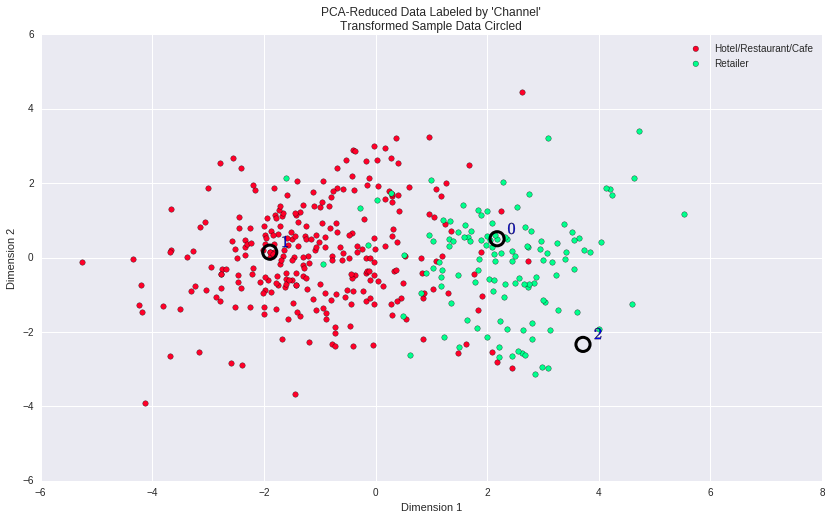

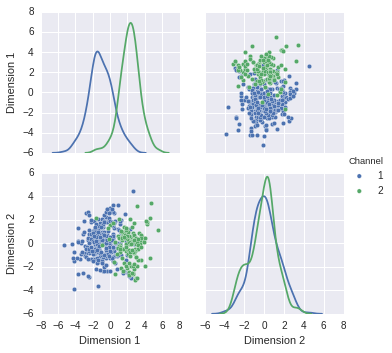

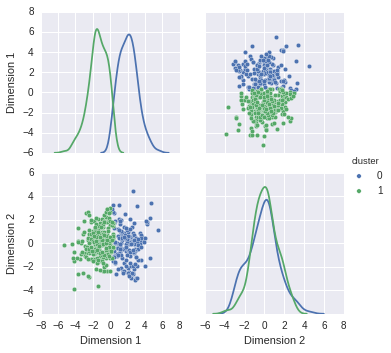

In [140]:
# Display the clustering results based on 'Channel' data

rs.channel_results(reduced_data, outliers.keys(), pca_samples)

full_data = pd.read_csv("customers.csv")
channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
channel = channel.drop(channel.index[outliers.keys()]).reset_index(drop = True)
labeled = pd.concat([reduced_data, channel], axis = 1)
labeled = pd.concat([labeled, pd.Series(preds, name='cluster')], axis=1)

sns.pairplot(labeled, hue='Channel',  diag_kind='kde', vars=('Dimension 1', 'Dimension 2'))
sns.pairplot(labeled, hue='cluster', diag_kind='kde', vars=('Dimension 1', 'Dimension 2'))

mislabeled =len(labeled[labeled.cluster != (labeled.Channel-1)])/ float(len(labeled))
print "There were %.2f%% \"mislabeled\" costumers" % (mislabeled*100) 

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

The number of clusters reflects the separation of HoReCa and Retailers. They also share similar distributions. 

In the data was found about 12% of costumers that were labeled to the "wrong" cluster and those could be our overlap of categories and that also corroborate to the use of the Gaussian Mixture Classifier. 

The previous definition of the customer segments has the following relation:


|  Segment/Cluster | Channel |
|------|------|
|   restaurants and coffee shops  | Holtel Restaurants and Cafe|
|   grocery store or hotel  | Retailers|


The definitions are consistent with the Channel feature values, although guessing that hotels would fit the second cluster/segment was inconsitent.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.